# Random Forest Trial
## Summary of Tasks:
1. Encode feature variables - improvement over trial 1 - encode job using dummy encoding (better than frequency encoding)
2. Stratified K-Fold cross validation to handle the data imbalance
2. Train random forest model
3. Use grid search to find best hyperparameters that produce best f1 score

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [40]:
data = pd.read_csv('../data/bank.csv')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no


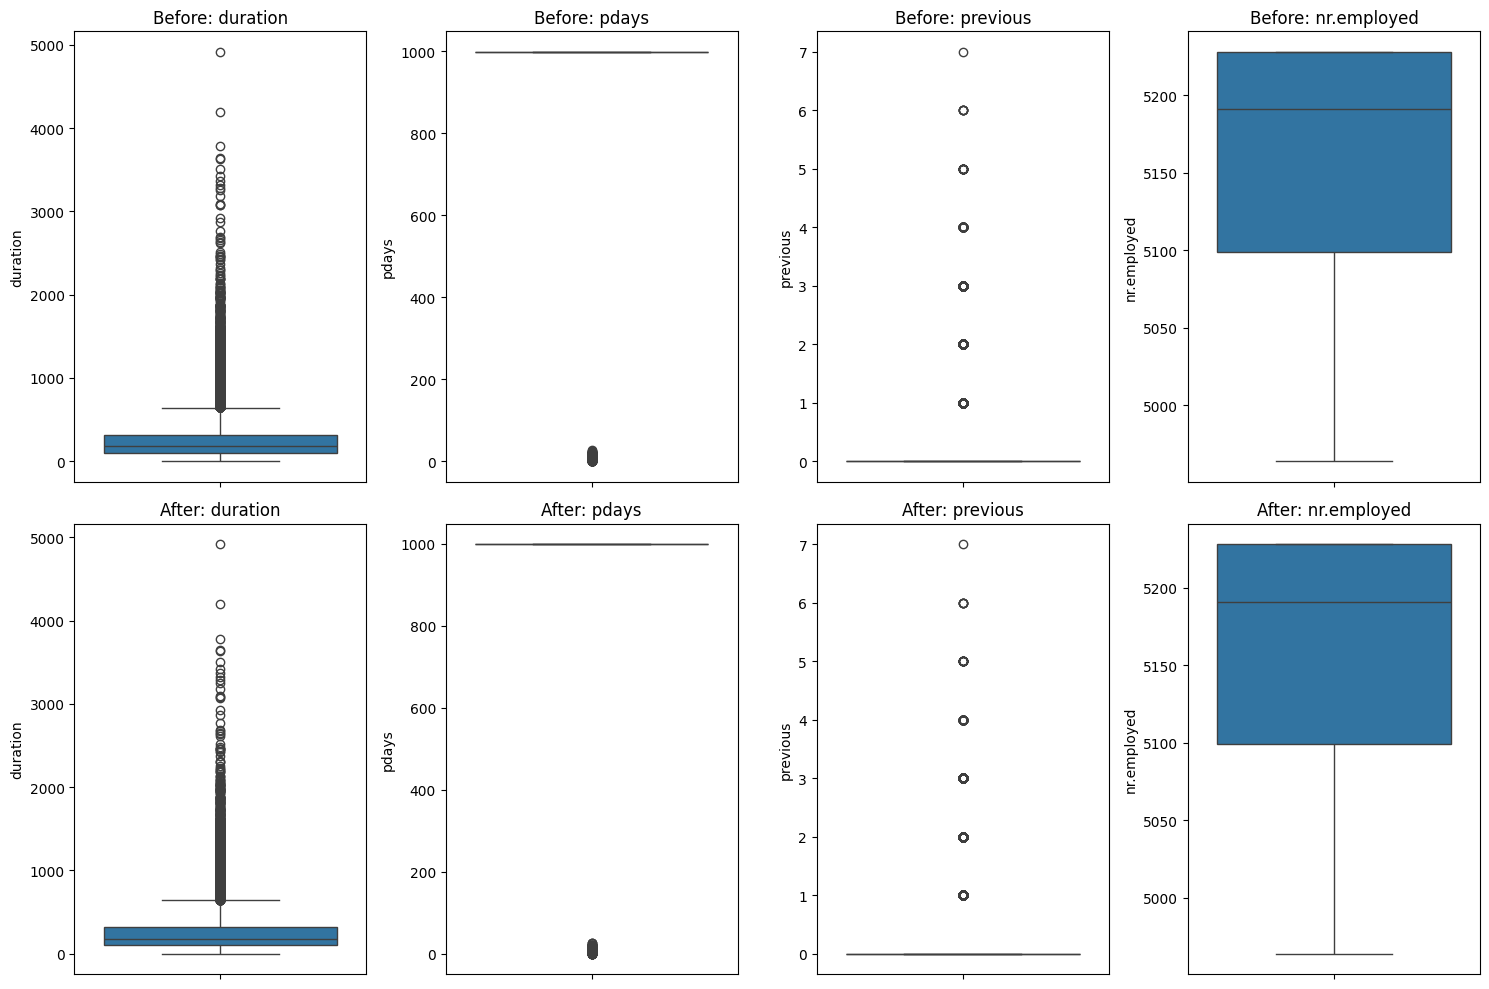

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns


# Define a function to handle outliers
def handle_outliers_iqr(column):
    # Calculate quartiles
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    # Calculate lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count occurrences of outliers
    outliers = (column < lower_bound) | (column > upper_bound)
    outlier_count = outliers.sum()

    # If the outlier count is less than 200, just return them as is
    if outlier_count < 200:
        return column.apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))
    else:
        # Round outliers to the upper or lower bound
        return column
    
num_cols = ['duration', 'pdays', 'previous', 'nr.employed']
# Apply outlier handling for each numerical column
for column in num_cols:
    data[column] = handle_outliers_iqr(data[column])

# Create subplots for the box plots before and after outlier handling
fig, axes = plt.subplots(nrows=2, ncols=len(num_cols), figsize=(15, 10))

# Plot box plots before outlier handling
for i, column in enumerate(num_cols):
    sns.boxplot(y=data[column], ax=axes[0, i])
    axes[0, i].set_title(f'Before: {column}')

# Plot box plots after outlier handling
for i, column in enumerate(num_cols):
    sns.boxplot(y=data[column], ax=axes[1, i])
    axes[1, i].set_title(f'After: {column}')

# Adjust layout and show plots
plt.tight_layout()
plt.show()

## Encoding categorical variables
One hot encoding: marital, poutcome, contact

Frequency encoding: job

Binary encoding: loan, housing, default, y

Ordinal encoding: education

sin/cosine encoding: month, day_of_week

In [42]:
# Encoding categorical data
# Using ordinal encoding for y
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(categories=[['no','yes']])
data['y_encoded'] = encoder.fit_transform(data[['y']])
data['pdays'] = data['pdays'].replace(999, 0)


# Using dummy encoding to encode marital, poutcome, contact, job
to_dummy_cols = pd.DataFrame(data[['marital', 'poutcome','contact', 'job']])
dummy_cols = pd.get_dummies(to_dummy_cols)


# Using binary encoding for loan, housing, default, y
from category_encoders import BinaryEncoder 
encoder = BinaryEncoder(cols =['loan', 'housing', 'default']) 
# Transforming the column after fitting
newdata = encoder.fit_transform(data[['loan', 'housing', 'default']])


# Using ordinal encoding for education
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(categories=[["illiterate","unknown","basic.4y","basic.6y","basic.9y","high.school","professional.course","university.degree"]])
data['education_encoded'] = encoder.fit_transform(data[['education']])

# Sin/cosine encoding for month, day_of_week
# Map categorical values to numerical values
month_mapping = {month: i+1 for i, month in enumerate(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
                                                       'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])}
day_mapping = {day: i+1 for i, day in enumerate(['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'])}

data['month_num'] = data['month'].map(month_mapping)
data['day_num'] = data['day_of_week'].map(day_mapping)

# Sine and Cosine Encoding
data['month_sin'] = np.sin(2 * np.pi * data['month_num'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month_num'] / 12)
data['day_sin'] = np.sin(2 * np.pi * data['day_num'] / 7)
data['day_cos'] = np.cos(2 * np.pi * data['day_num'] / 7)


# concatenating dataframe
data = pd.concat([data, newdata, dummy_cols], axis = 1) 
# dropping old column 
data = data.drop(['loan', 'housing', 'default','y','marital', 'poutcome','contact','job','month', 'day_of_week', 'month_num', 'day_num','education', 'duration'], axis = 1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 42 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   41188 non-null  int64  
 1   campaign              41188 non-null  int64  
 2   pdays                 41188 non-null  int64  
 3   previous              41188 non-null  int64  
 4   emp.var.rate          41188 non-null  float64
 5   cons.price.idx        41188 non-null  float64
 6   cons.conf.idx         41188 non-null  float64
 7   euribor3m             41188 non-null  float64
 8   nr.employed           41188 non-null  int64  
 9   y_encoded             41188 non-null  float64
 10  education_encoded     41188 non-null  float64
 11  month_sin             41188 non-null  float64
 12  month_cos             41188 non-null  float64
 13  day_sin               41188 non-null  float64
 14  day_cos               41188 non-null  float64
 15  loan_0             

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler

X = np.array(data.drop(['y_encoded'], axis=1))
y = np.array(data[['y_encoded']])

robust = RobustScaler()
X_scaled = robust.fit_transform(X)


In [44]:
# Calculate correlations with the target variable ('Income')
correlations = data.corr()['y'].sort_values(ascending=False)

# Print correlations
print(correlations)

KeyError: 'y'

In [45]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)




In [46]:
# STRATIFIES K-FOLD CROSS VALIDATION { 10-fold }

# Import Required Modules.
from statistics import mean, median, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import *

# Create classifier object.
rfc_skf = RandomForestClassifier(n_jobs=-1)

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
f1_stratified = []
class_reps = []

for train_index, test_index in skf.split(X_resampled, y_resampled):
	X_train_fold, X_test_fold = X_resampled[train_index], X_resampled[test_index]
	y_train_fold, y_test_fold = y_resampled[train_index], y_resampled[test_index]
	rfc_skf.fit(X_train_fold, y_train_fold)
	y_predict = rfc_skf.predict(X_test_fold)
	fold_f1 = f1_score(y_test_fold, y_predict, average='binary')  # Use 'binary' for binary classification
	f1_stratified.append(fold_f1)
	report = classification_report(y_test_fold, y_predict)
	class_reps.append(report)


# Print the output.
print('List of possible f1:', f1_stratified)
print('\nMaximum f1 That can be obtained from this model is:',
	max(f1_stratified)*100, '%')
rep = class_reps[f1_stratified.index(max(f1_stratified))]
print(rep)
print('\nMinimum f1:',
	min(f1_stratified)*100, '%')
rep = class_reps[f1_stratified.index(min(f1_stratified))]
print(rep)
print('\nOverall f1:',
	mean(f1_stratified)*100, '%')
# Find the index of the F1-score closest to the mean
closest_to_mean_index = min(range(len(f1_stratified)), key=lambda i: abs(f1_stratified[i] - mean(f1_stratified)))
mean_closest_report = class_reps[closest_to_mean_index]
print(mean_closest_report)
print('\nStandard Deviation is:', stdev(f1_stratified))


KeyboardInterrupt: 

In [12]:
print(class_reps)

['              precision    recall  f1-score   support\n\n         0.0       0.97      0.94      0.95      3654\n         1.0       0.94      0.97      0.95      3655\n\n    accuracy                           0.95      7309\n   macro avg       0.95      0.95      0.95      7309\nweighted avg       0.95      0.95      0.95      7309\n', '              precision    recall  f1-score   support\n\n         0.0       0.97      0.94      0.96      3655\n         1.0       0.94      0.97      0.96      3654\n\n    accuracy                           0.96      7309\n   macro avg       0.96      0.96      0.96      7309\nweighted avg       0.96      0.96      0.96      7309\n', '              precision    recall  f1-score   support\n\n         0.0       0.97      0.94      0.96      3655\n         1.0       0.94      0.97      0.96      3655\n\n    accuracy                           0.96      7310\n   macro avg       0.96      0.96      0.96      7310\nweighted avg       0.96      0.96      0.96

In [44]:
# Train basic random forest model now
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import *

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=31, test_size=0.2)

rfc = RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_jobs=-1,random_state=31)
rfc.fit(X_train, y_train)


# Checking scores
y_predict = rfc.predict(X_test)
y_predict_train = rfc.predict(X_train)
accuracy_test = accuracy_score(y_predict, y_test)
accuracy_train = accuracy_score(y_predict_train, y_train)
precision_test = precision_score(y_predict, y_test)
precision_train = precision_score(y_predict_train, y_train)
recall_test = recall_score(y_predict, y_test)
recall_train = recall_score(y_predict_train, y_train)
f1_test = f1_score(y_predict, y_test)
f1_train = f1_score(y_predict_train, y_train)

# Printing out results
# Predicting the accuracy score for Random Forest Classifier 
print('\n')
print('-------Random Forest Classifier-------')
print('accuracy for test is', accuracy_test)
print('accuracy for train is', accuracy_train)
print('\n')
print('precision for test is', precision_test)
print('precision for train is', precision_train)
print('\n')
print('recall for test is', recall_test)
print('recall for train is', recall_train)
print('\n')
print('f1 for test is', f1_test)
print('f1 for train is', f1_train)
print('\n')


print(classification_report(y_test, y_predict))




-------Random Forest Classifier-------
accuracy for test is 0.942749658002736
accuracy for train is 0.9655072166358848


precision for test is 0.9732459732459733
precision for train is 0.9860379166381493


recall for test is 0.9175138334834642
recall for train is 0.9471123820793479


f1 for test is 0.944558521560575
f1 for train is 0.9661832509011652


              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94      7294
         1.0       0.92      0.97      0.94      7326

    accuracy                           0.94     14620
   macro avg       0.94      0.94      0.94     14620
weighted avg       0.94      0.94      0.94     14620



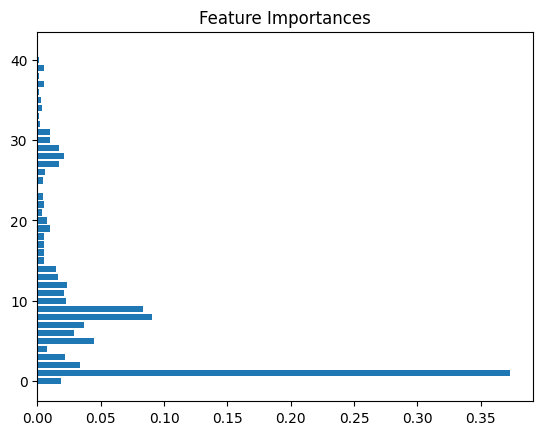

In [45]:
importances = rfc.feature_importances_
feature_names = pd.DataFrame(X_resampled).columns
plt.barh(feature_names, importances)
plt.title("Feature Importances")
plt.show()


In [46]:
rf = RandomForestClassifier(random_state=31, n_jobs=-1)

params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200],
    'max_features': ['auto', 'sqrt', 'log2'],

}

from sklearn.model_selection import GridSearchCV

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 5,
                           n_jobs=-1, verbose=1, scoring="f1")

grid_search.fit(X_train, y_train)
print(grid_search.best_score_)
rf_best = grid_search.best_estimator_
print(rf_best)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
0.9439839304307407
RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=200,
                       n_jobs=-1, random_state=31)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from sklearn.metrics import *

X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, random_state=31, test_size=0.2)

# Define the neural network architecture
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],)), # Input layer
    Dropout(0.1), # To prevent overfitting
    Dense(96, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid') # Output layer - Binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    verbose=1, 
                    )

# Evaluate the model based on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation loss: {val_loss}')
print(f'Validation accuracy: {val_accuracy}')

# Generate classification report
from sklearn.metrics import classification_report

# Predict on validation data
y_predict = (model.predict(X_val)>0.5).astype("int32")
print(classification_report(y_val, y_predict))

Epoch 1/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8598 - loss: 0.3390 - val_accuracy: 0.8850 - val_loss: 0.2777
Epoch 2/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8884 - loss: 0.2728 - val_accuracy: 0.8909 - val_loss: 0.2689
Epoch 3/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8930 - loss: 0.2682 - val_accuracy: 0.8938 - val_loss: 0.2676
Epoch 4/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8940 - loss: 0.2659 - val_accuracy: 0.8966 - val_loss: 0.2591
Epoch 5/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8985 - loss: 0.2581 - val_accuracy: 0.8984 - val_loss: 0.2624
Epoch 6/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8995 - loss: 0.2531 - val_accuracy: 0.8988 - val_loss: 0.2565
Epoch 7/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9031 - loss: 0.2495 - val_accuracy: 0.8997 - val_loss: 0.2595
Epoch 8/50
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9016 - loss: 0.2531 - 

KeyboardInterrupt: 

In [34]:
from keras_tuner import HyperModel

# Define the hypermodel class
class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()

        # Input layer - 1st hidden layer
        model.add(Dense(units=hp.Int('units_input', min_value=64, max_value=256, step=32),
                        activation='relu', input_shape=(X_train.shape[1],)))
        
        # Add a dropout layer
        model.add(Dropout(rate=hp.Float('dropout_input', min_value=0.1, max_value=0.5, step=0.1)))

        # Second hidden layer
        model.add(Dense(units=hp.Int('units_hidden', min_value=32, max_value=128, step=32), activation='relu'))
        
        # Add a dropout layer
        model.add(Dropout(rate=hp.Float('dropout_hidden', min_value=0.1, max_value=0.5, step=0.1)))

        # Add the output layer
        model.add(Dense(1, activation='sigmoid')) # Binary classification

        # Compile the model
        model.compile(
            optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
            loss = 'binary_crossentropy',
            metrics=['accuracy']
        )
        return model
    

In [35]:
from keras_tuner.tuners import RandomSearch

# Initialize the tuner
tuner = RandomSearch(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_tuning_dir',
    project_name='bank_ann'
)

tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=20,
             batch_size=32)

# Show a summary of the search
tuner.results_summary()

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The best number of units for the input layer is {best_hps.get('units_input')},
Dropout rate for input layer is {best_hps.get('dropout_input')},
Hidden layer units are {best_hps.get('units_hidden')},
Dropout rate for hidden layer is {best_hps.get('dropout_hidden')},
and the optimizer is {best_hps.get('optimizer')}.
""")



Trial 3 Complete [00h 02m 14s]
val_accuracy: 0.9167236685752869

Best val_accuracy So Far: 0.9209986329078674
Total elapsed time: 00h 06m 35s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
160               |96                |units_input
0.3               |0.4               |dropout_input
96                |32                |units_hidden
0.2               |0.1               |dropout_hidden
rmsprop           |adam              |optimizer

Epoch 1/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8637 - loss: 0.3350 - val_accuracy: 0.8872 - val_loss: 0.2751
Epoch 2/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8914 - loss: 0.2714 - val_accuracy: 0.8954 - val_loss: 0.2642
Epoch 3/20
1828/1828 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9008 - loss: 0.2578 - val_accuracy: 0.8989 - val_loss: 0.2608
Epoch 4/20
 449/1828 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8989 - loss: 0.2606

KeyboardInterrupt: 

In [ ]:
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(X_train, y_train,
                         validation_data=(X_val, y_val),
                        epochs=50,
                        batch_size=32,
                        verbose=1)

# Save the best model
best_model.save('best_neural_network_model.h5')

# Predict on validation data
y_pred = (best_model.predict(X_val) > 0.5).astype("int32")

# Print classification report
print(classification_report(y_val, y_pred))